In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt

from glob import glob

from dataset import *

# This is a hack to be able to import modules in parent directory
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

# But with fonts from the document body
#plt.style.use('seabo')

#plt.rcParams.update({
#    "font.family": "serif",  # use serif/main font for text elements
#    "text.usetex": True,     # use inline math for ticks
#    "pgf.rcfonts": False     # don't setup fonts from rc parameters
#    })

In [2]:
datasets = {
            0: deepmatcher_structured_amazon_google,
            1: deepmatcher_structured_dblp_acm,
            2: deepmatcher_structured_dblp_google_scholar,
            3: deepmatcher_structured_itunes_amazon,
            4: deepmatcher_structured_walmart_amazon,
            5: deepmatcher_textual_abt_buy,
}

In [6]:
def save_plots(models=['distillbert-1402'], specific=-1, x='labeled_instances', y=['test_f1'], plots=['exp1', 'exp3', 'random'], f1_all = False, **kwargs):
    """
    Main function for saving plots based on test results
    params:
    models: list of folder names you want to plot
    specific: specify dataset by key in datasets,
    x: value to use on x-axis
    y: list of values to use on y-axis
    plots: list of predefined experiments to be included
    f1_all: True if you want a red line of maximum f1 score in graph
    """
    models = sorted(models)
    cols = y[:]
    cols.append(x)
    if specific == -1:
        for key in datasets:
            _plot_results(models, key, x, y, cols, plots, f1_all)
    
    else:
        _plot_results(models, specific, x, y, cols, plots, f1_all)

def _plot_results(models, key, x, y, cols, plots, f1_all):
    d = datasets[key]()
    scores = {}
    predictions = {}
    max_f1 = None
    
    for model in models:
        for filename in sorted(glob(f'{model}/out/{d.name}/*.csv')):
            if 'exp1' and 'predictions' in filename:
                p = pd.read_csv(filename, header=0)
                predictions[f'{model}_datasetdl_predictions'] = d
            elif 'exp1' in filename and not 'predictions' in filename:
                s = pd.read_csv(filename, usecols=cols, header=0)
                scores[f'{model}_exp1'] = s
            elif 'exp3' and 'random' in filename:
                if f1_all: max_f1 = pd.read_csv(filename, header=0)['test_f1'].iloc[[-1]].to_numpy()[-1]
                s = pd.read_csv(filename, usecols=cols, header=0)
                s.drop(s.tail(1).index,inplace=True)
                scores[f'{model}_random'] = s
            elif 'exp3' and 'al' in filename:
                s = pd.read_csv(filename, usecols=cols, header=0)
                scores[f'{model}_exp3'] = s
    
    collection = {}
    for key in scores:
        for plot in plots:
            if plot in key:
                collection[key] = scores[key]
        
    _make_plot(collection, x, y, d, models, plots, max_f1)
    
def _make_plot(scores, x, y, d, models, plots, max_f1, **kwargs): 
    plt.figure(num=None, figsize=(set_size(345)), dpi=80, facecolor='w', edgecolor='k') # set size of plot
    titles = []
    
    for key in scores:
        for val in y:
            plt.plot(scores[key][x], scores[key][val])
            titles.append(f'{key}_{val}')
    
    if max_f1 is not None:
        plt.axhline(y=max_f1, color='r')
        titles.append(f'{key}_all')

    #plt.xticks(scores[list(scores.keys())[-1]][x])  # set values of points on x axis
    plt.margins(0.01) # set margins to 0.01
    plt.legend(titles, loc=4) # add titles of plots, 4 = lower right, 2 = upper left
    title = d.name.split('/')[-1]
    plt.title(title)
    plt.xlabel('x');
    
    try:
        path = os.path.join('graps', f'{"_".join(models)}', f'{"_".join(plots)}')
        os.makedirs(path)
    except OSError as e:
        print(e.strerror)
    
    plt.savefig(f'{path}/{title}_{"_".join(y)}.pdf', format='pdf', bbox_inches='tight')

def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

File exists
File exists
File exists
File exists
File exists
File exists


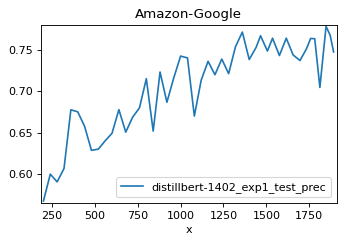

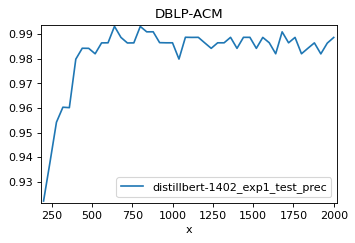

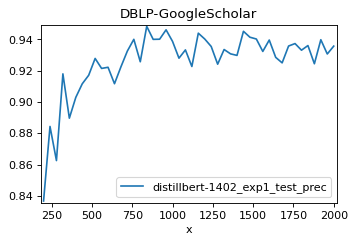

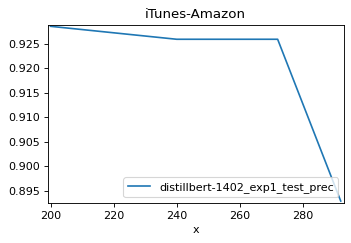

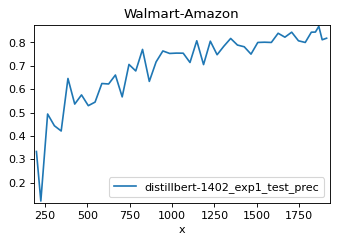

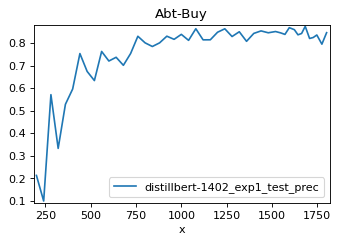

In [11]:
# plots=['exp1', 'exp3', 'random']
save_plots(models=['distillbert-1402'], y=['test_prec'], x='labeled_instances', plots=['exp1'])

In [ ]:
# plots=['exp1', 'exp3', 'random']
save_plots(models=['distillbert-1402'], y=['iteration_time'], x='labeled_instances', plots=['exp1','exp3'])

In [ ]:
save_plots(models=['roberta-1602', 'distillbert-1402'], y=['test_f1'], plots=['exp3'])

In [ ]:
# plots=['dl_ml', 'dl_random', 'dl_al_ml']
save_plots(models=['distillbert-1402', 'roberta-1602'], y=['iteration_time'], plots=['exp1'])